# Optoelectronic Systems Theory Assignment

In [1]:
import numpy as np
from scipy import signal, constants
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Initial data

In [2]:
wavelength = 0.8e-3 # mm
focus = 90 # mm
T = 5000 # K
mu = 0.6e-3 # mm
sigma = 0.1e-3 # mm

## Utility functions

In [3]:
def triangle(x):
    return np.where(np.abs(x) <= 1, 1 - np.abs(x), 0)

def rect(x):
    return np.where(np.abs(x) <= 0.5, 1, 0)

def sinc(x):
    return np.where(x == 0, 1, np.sin(x) / x)

## Pupil function

### Pupil variants

![](images/pupil_variants.png)

In [4]:
def pupil(x):
    return rect((x - 3) / 3) + rect((x + 3) / 3)

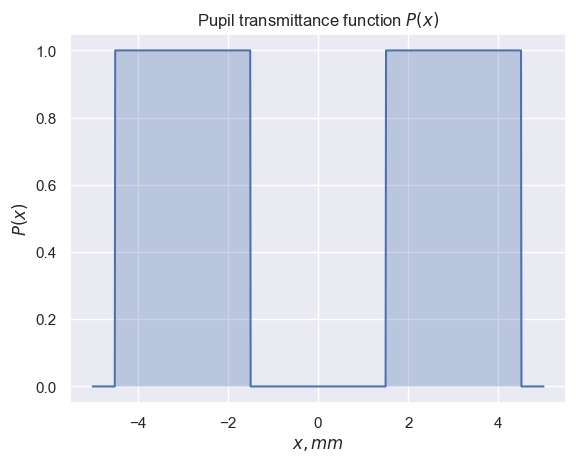

In [5]:
x = np.linspace(-5, 5, 1000)

fig, ax = plt.subplots()
ax.set_title('Pupil transmittance function $P(x)$')
ax.set_xlabel('$x, mm$')
ax.set_ylabel('$P(x)$')
ax.plot(x, pupil(x))
ax.fill_between(x, pupil(x), alpha=0.3)
plt.show()

## Part 1

For a cylindrical diffraction-limited optical system, on which a plane monochromatic wave with length $\lambda$ and amplitude $A=1$ falls, find:

1. A coherent transfer function $\tilde{h}(\nu_x)$ and plot its graph
2. An optical transfer function $\tilde{H}_N^{OS}(\nu_x)$ and plot its graph

![](images/optical_system.png)

In [6]:
pupil_diameter = 10
max_frequency = pupil_diameter / (wavelength * focus)
print('Max frequency = {:.3f} [1/mm]'.format(max_frequency))

Max frequency = 138.889 [1/mm]


In [7]:
def transfer_function(frequencies, wavelength, focus):
    return signal.convolve(pupil(-frequencies * wavelength * focus), pupil(frequencies * wavelength * focus), 'same')

def transfer_function_n(frequencies, wavelength, focus):
    result = transfer_function(frequencies, wavelength, focus)
    return result / np.max(result)

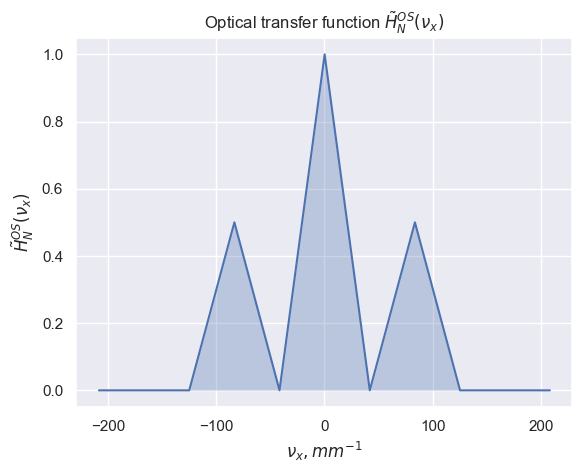

In [8]:
freq = np.linspace(-max_frequency * 1.5, max_frequency * 1.5, 1000)
H = transfer_function_n(freq, wavelength, focus)

fig, ax = plt.subplots()
ax.set_title('Optical transfer function $\\tilde{H}_N^{OS}(\\nu_x)$')
ax.set_xlabel('$\\nu_x, mm^{-1}$')
ax.set_ylabel('$\\tilde{H}_N^{OS}(\\nu_x)$')
ax.plot(freq, H)
ax.fill_between(freq, H, alpha=0.3)
plt.show()

## Part 2

Find a polychromatic transfer function $\tilde{H}^{PC}(\nu_x)$ for the radiation of a corresponding blackbody with temperature $T$, if the image is formed in the rear focal plane, and the spectral sensitivity of the radiation receiver is approximated by a Gaussian distribution with a mathematical expectation of 600 nm and a standard deviation of 100 nm.

In [9]:
wien = constants.value('Wien wavelength displacement law constant')
wavelength_peak = wien * 1e3 / T
print('Blackbody wavelength peak = {:} mm'.format(wavelength_peak))

Blackbody wavelength peak = 0.000579554391 mm


In [10]:
def sensitivity_n(wavelength):
    return np.exp(-(wavelength - mu) ** 2 / (2 * sigma ** 2))

def luminance(wavelength):
    c = constants.c * 1e3 # mm
    numerator = 4 * (c ** 2) * constants.hbar
    exp = np.exp((2 * np.pi * constants.hbar * c) / (wavelength * constants.k * T))
    denominator = (wavelength ** 5) * (exp - 1)

    return numerator / denominator

def luminance_n(wavelength):
    return luminance(wavelength) / luminance(wavelength_peak)

C:\Users\Maksim Vinogradov\AppData\Local\Temp\ipykernel_19260\2852790975.py:7: RuntimeWarning: divide by zero encountered in divide
  exp = np.exp((2 * np.pi * constants.hbar * c) / (wavelength * constants.k * T))
C:\Users\Maksim Vinogradov\AppData\Local\Temp\ipykernel_19260\2852790975.py:7: RuntimeWarning: overflow encountered in exp
  exp = np.exp((2 * np.pi * constants.hbar * c) / (wavelength * constants.k * T))
C:\Users\Maksim Vinogradov\AppData\Local\Temp\ipykernel_19260\2852790975.py:8: RuntimeWarning: invalid value encountered in multiply
  denominator = (wavelength ** 5) * (exp - 1)


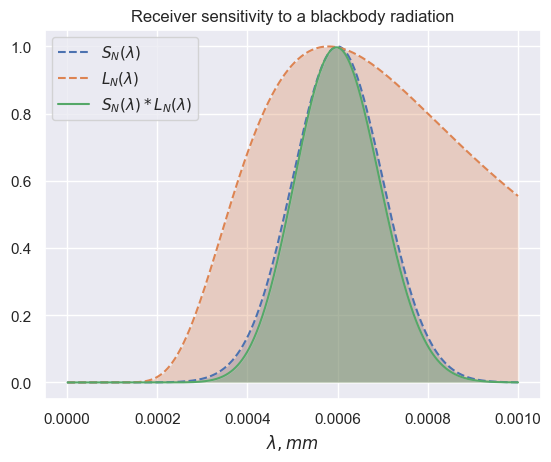

In [11]:
wv = np.linspace(0, 1e-3, 1000)

S = sensitivity_n(wv)
L = luminance_n(wv)
common_sensitivity = S * L

fig, ax = plt.subplots()
ax.set_title('Receiver sensitivity to a blackbody radiation')
ax.set_xlabel('$\\lambda, mm$')
ax.plot(wv, S, label='$S_N(\\lambda)$', linestyle='dashed')
ax.fill_between(wv, S, alpha=0.3)
ax.plot(wv, L, label='$L_N(\\lambda)$', linestyle='dashed')
ax.fill_between(wv, L, alpha=0.3)
ax.plot(wv, common_sensitivity, label='$S_N(\\lambda) * L_N(\\lambda)$')
ax.fill_between(wv, common_sensitivity, alpha=0.3)
ax.legend()
plt.show()

In [12]:
start_index = np.argmax(common_sensitivity >= 0.01)
end_index = len(common_sensitivity) - np.argmax(common_sensitivity[::-1] >= 0.01)

start_wavelength = wv[start_index]
end_wavelength = wv[end_index]

print('Meaningful wavelength interval from {:.1e} mm to {:.1e} mm'.format(start_wavelength, end_wavelength))

Meaningful wavelength interval from 3.3e-04 mm to 8.9e-04 mm


In [13]:
def transfer_function_polychromatic(frequencies, start_wavelength, end_wavelength):
    delta_wavelength = 1e-5
    wavelength_range = np.arange(start_wavelength, end_wavelength, delta_wavelength)
    
    numerator = np.sum([transfer_function_n(frequencies, wv, focus) * sensitivity_n(wv) * luminance_n(wv) * delta_wavelength for wv in wavelength_range], 0)
    denominator = np.sum([sensitivity_n(wv) * luminance_n(wv) * delta_wavelength for wv in wavelength_range])

    return numerator / denominator

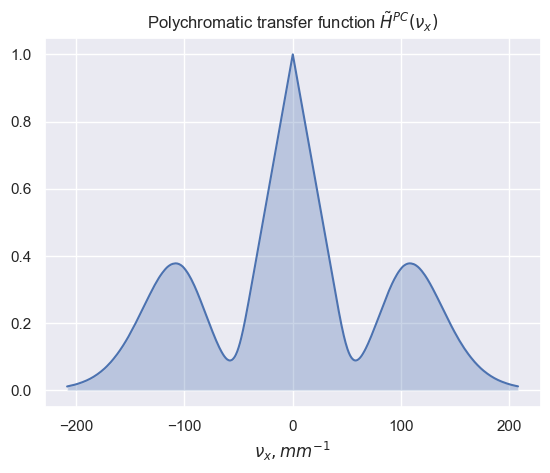

In [14]:
H_pc = transfer_function_polychromatic(freq, start_wavelength, end_wavelength)

fig, ax = plt.subplots()
ax.set_title('Polychromatic transfer function $\\tilde{H}^{PC}(\\nu_x)$')
ax.set_xlabel('$\\nu_x, mm^{-1}$')
ax.plot(freq, H_pc)
ax.fill_between(freq, H_pc, alpha=0.3)
plt.show()

## Part 3

Find the time-frequency spectrum of the radiation flux $\tilde{\Phi}_t(\nu_t)$ and the magnitude of the radiation flux $\Phi_t(t)$ in the image analysis plane of the optical system at the output of the modulator of the image analyzer during its linear scanning and plot their graphs. The optical system is a lens with a normalized scattering function $H_N^{OS}(x', y')=\delta(x', y')$, the source of radiation is an object in the form of a rectangle with a constant energy brightness $L_0$, the study of which obeys Lambert's law. The modulator of the image analyzer is a lattice with a cosine distribution of the transmission coefficient along the $x$ axis.

![](images/modulator_of_image_analyzer.png)

## Initial data

In [15]:
b = 6 # mm
beta = 0.5
period_x = 2.5 # mm
vel_x = 90 # mm/s
c = 1 # mm
sigma_aperture = 7 # deg
tau = 1
luminance_0 = 0.7e-6 # W / (mm^2 * srad)

## Flux function

In [16]:
flux_0 = 0.5 * np.pi * tau * np.sin(sigma_aperture * (np.pi / 180)) ** 2 * luminance_0 * 2 * b * 2 * c

def flux(t):
    return flux_0 + flux_0 * sinc(2 * np.pi * b * beta / period_x) * np.cos(2 * np.pi * vel_x / period_x * t)

print('Main flux component {:.3e} W'.format(flux_0))

Main flux component 3.919e-07 W


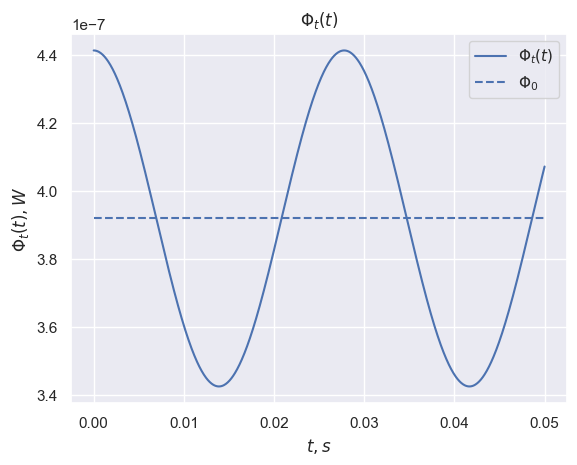

In [17]:
t = np.linspace(0, 0.05, 1000)

fig, ax = plt.subplots()
ax.set_title('$\\Phi_t(t)$')
ax.set_xlabel('$t, s$')
ax.set_ylabel('$\\Phi_t(t), W$')
ax.plot(t, flux(t), label='$\\Phi_t(t)$')
ax.hlines(flux_0, t[0], t[-1], linestyles='dashed', label='$\\Phi_0$')
ax.legend()
plt.show()